# Maize read length distribution shift

# First read in the read lengths for the Maize b73 data

In [1]:
b73_rc = [int(l.strip()) for l in open('b73.csv')]

In [2]:
sum(b73_rc)

156402786403

In [3]:
nc358_size = 2272400000

# Calculate the size of this data in terms of the Maize genome

In [4]:
coverage = sum(b73_rc) / float(nc358_size)
print coverage

68.8271371251


In [5]:
target_coverage = 50.0

In [6]:
downsample_ratio = target_coverage/ coverage
print downsample_ratio

0.726457645756


# Now downsample the reads to have the target read length distribution

In [7]:
import numpy as np

In [8]:
maize_target_distribution = [r for r in b73_rc if np.random.uniform() < downsample_ratio]

In [9]:
sum(maize_target_distribution) / float(nc358_size)

49.99159070806196

# Load the maize distribution

In [10]:
maize_starting_distribution = [int(l.strip()) for l in open('maize_raw_rc.csv')]

In [11]:
maize_starting_coverage = sum(maize_starting_distribution) / float(nc358_size)
print maize_starting_coverage

75.2881381438


In [12]:
print len(maize_starting_distribution)
print len(maize_target_distribution)

13793126
9776359


### Note that our target distribution has more reads than all of our starting data.  This means that we won't quite get the coverage we hoped for.

In [13]:
maize_target_distribution_modified = maize_target_distribution[:len(maize_starting_distribution)]
print sum(maize_target_distribution_modified) / float(nc358_size)

49.9915907081


### That's pretty close though!

# Let's make some helper functions

In [14]:
from matplotlib import pyplot as plt

In [15]:
%matplotlib inline

In [16]:
def calc_pdf(data):
    max_val = max(data)
    total = sum(data)
    prob = np.zeros(max_val+1)
    
    for d in data:
        prob[d] += 1
    
    prob = [p/float(total) for p in prob]
    
    return prob

In [17]:
def calc_cumsum(data):
    total = sum(data)
    data = sorted(data)
    data = np.cumsum(data)
    data = [d/float(total) for d in data]
    
    return data

In [18]:
def calc_n50(data):
    data = sorted(data)
    total = sum(data)
    norm_data = np.cumsum(data) / float(total)
    idx = np.searchsorted(norm_data, 0.5)
    
    return data[idx]

# And do a sanity check to ensure that the distributions are the same

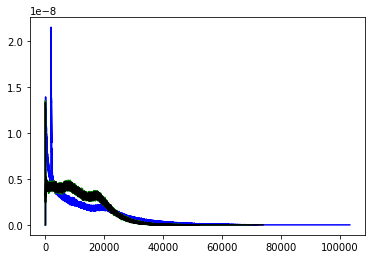

In [19]:
plt.plot(calc_pdf(maize_starting_distribution),'b', label='Maize starting')
plt.plot(calc_pdf(maize_target_distribution),'g', label='Maize target')
plt.plot(calc_pdf(b73_rc),'k', label='b73')

In [20]:
print len(maize_starting_distribution)
print len(maize_target_distribution)

13793126
9776359


(array([  1.86703000e+05,   1.93994000e+05,   1.76104000e+05,
          1.55990000e+05,   1.41046000e+05,   1.31273000e+05,
          1.23935000e+05,   1.19852000e+05,   1.12799000e+05,
          1.10058000e+05,   1.04361000e+05,   1.02539000e+05,
          9.87570000e+04,   9.52430000e+04,   9.35250000e+04,
          9.23370000e+04,   8.96730000e+04,   1.32738000e+05,
          3.12863000e+05,   1.92296000e+05,   1.34548000e+05,
          1.05099000e+05,   9.21850000e+04,   8.54550000e+04,
          8.14780000e+04,   7.78460000e+04,   7.61210000e+04,
          7.38920000e+04,   7.20400000e+04,   7.14680000e+04,
          7.08600000e+04,   7.04950000e+04,   6.85150000e+04,
          6.81230000e+04,   6.72290000e+04,   6.66520000e+04,
          6.62640000e+04,   6.68020000e+04,   6.48890000e+04,
          6.44550000e+04,   6.31090000e+04,   6.33830000e+04,
          6.22090000e+04,   6.14630000e+04,   6.02760000e+04,
          6.06110000e+04,   5.99700000e+04,   5.89640000e+04,
        

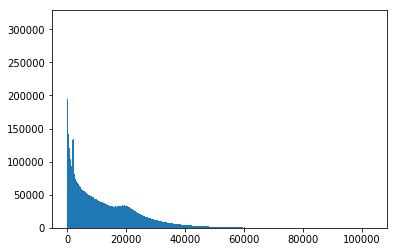

In [21]:
plt.hist(maize_starting_distribution, label='Maize starting',bins=1000)

## Interesting, it looks like we have fewer reads in all of the maize data than our downsampled target distribution
Let's see what the coverage is if we were to use the same number of reads

In [22]:
print sum(maize_target_distribution[:len(maize_starting_distribution)]) / float(nc358_size)

49.9915907081


## O.K., I think this probably will work
We'll plan on actually trimming the reads that we have rather than just down-sample.

In [23]:
maize_starting_sorted_with_index = sorted(zip(maize_starting_distribution, xrange(len(maize_starting_distribution))), key=lambda x: x[0], reverse=True)
maize_target_distribution_sorted = sorted(maize_target_distribution[:len(maize_starting_distribution)], reverse=True)

In [24]:
from itertools import izip

In [25]:
maize_new_distribution = []
missing = 0
for maize, target in izip(maize_starting_sorted_with_index, maize_target_distribution_sorted):
    if maize[0] > target:
        diff = min(missing, maize[0] - target)
        missing -= diff
        maize_new_distribution.append((target + diff, maize[1]))
    else:
        maize_new_distribution.append(maize)
        #missing += target - maize[0]
        missing = 0

In [26]:
new_maize_dist = [r[0] for r in maize_new_distribution]
print sum(new_maize_dist) / float(nc358_size)

49.9915907081


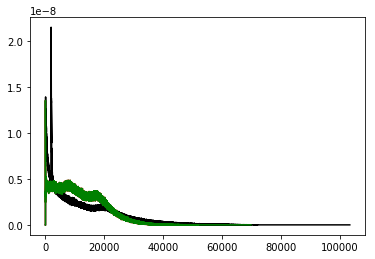

In [30]:
plt.plot(calc_pdf(new_maize_dist),'r')
plt.plot(calc_pdf(maize_starting_distribution),'k')
plt.plot(calc_pdf(maize_target_distribution_sorted),'g')


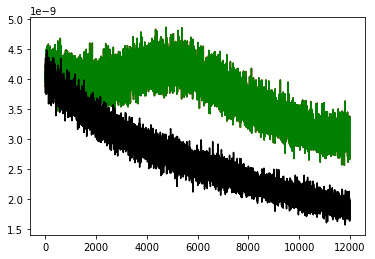

In [31]:
plt.plot(calc_pdf(new_maize_dist)[3000:15000],'r')
plt.plot(calc_pdf(maize_target_distribution_sorted)[3000:15000],'g')
plt.plot(calc_pdf(maize_starting_distribution)[3000:15000],'k')

In [32]:
print calc_n50(new_maize_dist)
print calc_n50(maize_target_distribution_sorted)
print calc_n50(maize_starting_distribution)

16764
16764
21166


### Note the weird discontinuity in the dist chart above at a read length of 5810.  Below you can see that at this read length, we have an inflection point in the # of reads, so that there are much fewer reads for a given length.

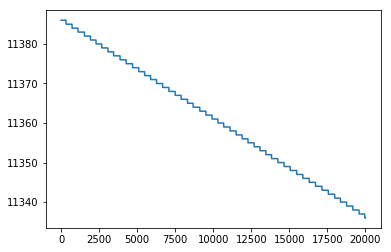

In [33]:
plt.plot(new_maize_dist[-5250000:-5230000])

## O.K., so we can almost get the same distribution.  At the low read lengths, it doesn't match great, but at the longer reads it's looking good.

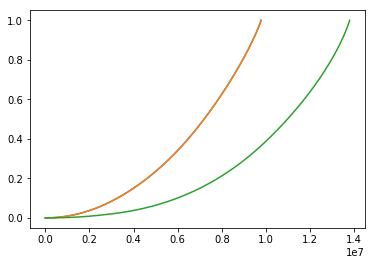

In [34]:
plt.plot(calc_cumsum(new_maize_dist))
plt.plot(calc_cumsum(maize_target_distribution_sorted))
plt.plot(calc_cumsum(maize_starting_distribution))

## We matched the distributions pretty well...
Now let's sort the dist back in the proper order

In [39]:
maize_new_distribution_proper_order = sorted(maize_new_distribution, key=lambda x: x[1])

In [50]:
maize_new_distribution_proper_order_no_indices = [(r[0],r[1]) for r in maize_new_distribution_proper_order]

In [51]:
maize_new_distribution_proper_order[:5]

[(9254, 0), (10801, 1), (25780, 2), (155, 4), (15522, 5)]

In [52]:
with open('desired_read_lengths.csv', 'w') as fh:
    for l in maize_new_distribution_proper_order_no_indices:
        fh.write('{0}\n'.format(l))

In [53]:
maize_new_distribution_proper_order[0:10]

[(9254, 0),
 (10801, 1),
 (25780, 2),
 (155, 4),
 (15522, 5),
 (4281, 6),
 (22265, 7),
 (22766, 8),
 (18912, 9),
 (11491, 11)]